In [98]:
import pandas as pd
import re
from nltk.corpus import stopwords
import redditcleaner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gensim
import gensim.corpora as corpora
import nltk
from tqdm import tqdm
from gensim.models.coherencemodel import CoherenceModel
import warnings
from gensim import corpora, models
import en_core_web_sm
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pprint import pprint
import pickle

In [103]:
#dataset
df_pre = pd.read_csv('personalfinance.csv',delimiter=";")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 96, saw 2


In [86]:
df_pre.head()

,Body,Post_id,User_id,Reply_to
0,Hey guys! About a month ago I made a post tell...,13ifdbp,bpclc2lk,NaN
1,"> Instead of putting phrases like ""I maintaine...",jk9ifux,11m62d,bpclc2lk
2,Can you post your resume? 11 interviews in 150...,jka8fmv,dkxm55de,bpclc2lk
3,Were you only cold applying or reaching out to...,jka1jam,cbfvc,bpclc2lk
4,Congrats on now having two jobs 😁,jk9pd7p,nplmhrb,bpclc2lk


In [87]:

df_pre['Body'] = df_pre['Body'].astype('str')


## Preprocessing Body Text

In [88]:
#Removing stop words
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
df_pre['subm_text_processed'] = df_pre['Body'].map(lambda x: re.sub(pattern, '', x))
#redditclean
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(redditcleaner.clean)
#Removing x200b
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('x200b', '', x))
#Removing url links
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x))
#Removing ampersands
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('amp', '', x))
#Removing nan
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('nan', '', x))
#Removing new line tabs
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('[\n]', '', x))
# Remove punctuation
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('[,\.*!?]', '', x))
# Convert the titles to lowercase
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_pre['subm_text_processed'].head()

0    hey guys about month ago i made post telling f...
1    > instead putting phrases like "i maintained s...
2    can post resume 11 interviews 150 apps good as...
3    were cold applying reaching people companies w...
4                                  congrats two jobs 😁
Name: subm_text_processed, dtype: object

### Common Words in Submissions

In [89]:
# Join the different processed titles together.
long_string_pre = ','.join(list(df_pre['subm_text_processed'].values))


# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')


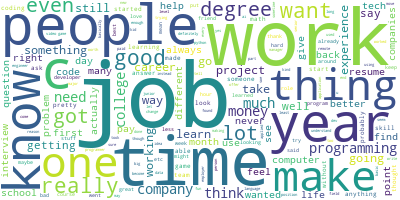

In [90]:
wordcloud.generate(long_string_pre)
wordcloud.to_image()

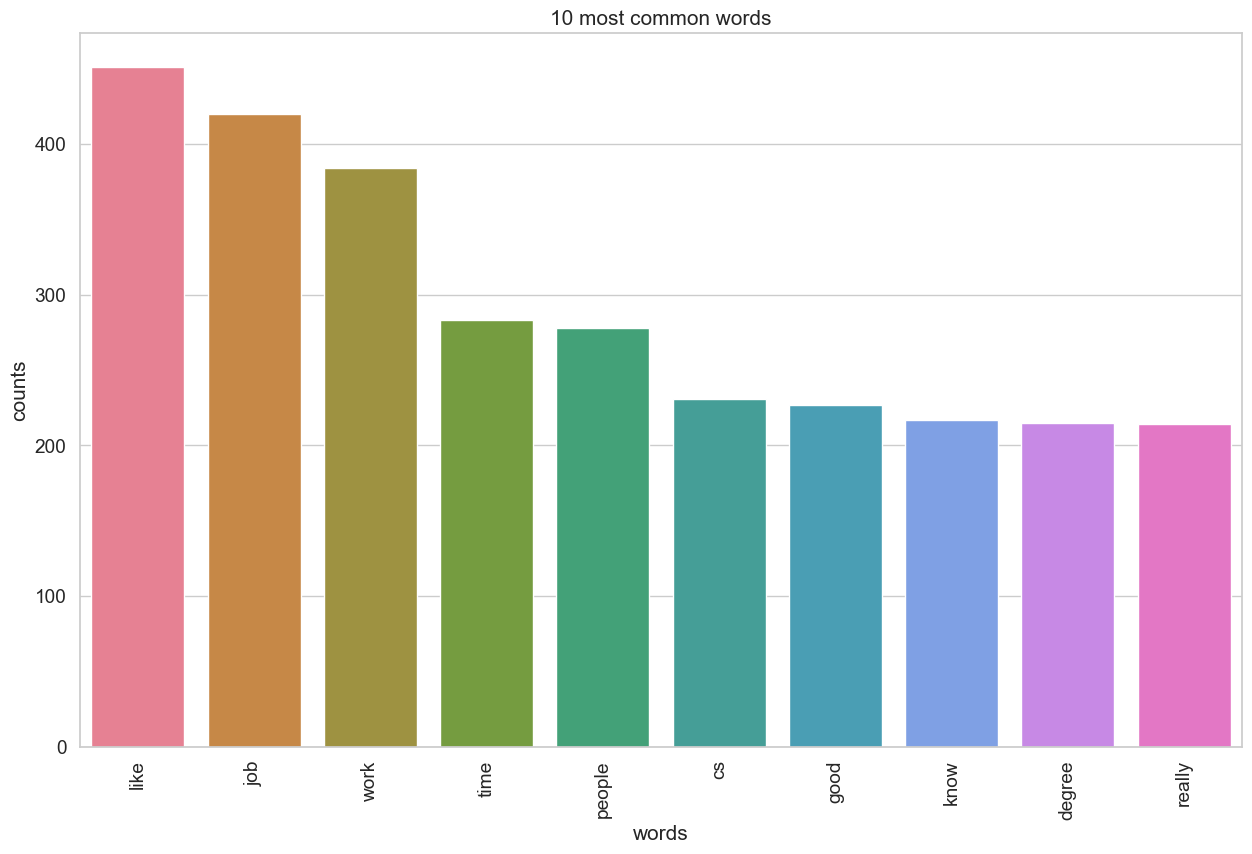

In [91]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]

    x_pos = np.arange(len(words)) 

    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialize the count vectorizer with the English stop words
count_vectorizer_pre = CountVectorizer(stop_words='english')

# Fit and transform the processed titles

count_data_pre = count_vectorizer_pre.fit_transform(df_pre['subm_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_pre, count_vectorizer_pre)

## Building LDA Topic Model

### Creating the baseline model

In [92]:
stopwords = nltk.corpus.stopwords.words('english')

#filtering out frequent words that appeared multiple times in topics
top_words = ["like","job","work","time","people","cs","good","know","degree","really"] #append the top 10 words to stopwords

stopwords.extend(top_words)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

        
def tokenization_with_gen_stop(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)

    return result

In [93]:
#nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()
nlp_pre = en_core_web_sm.load()

# data_lemma = []
data_lemma_pre = []

stopwords = nltk.corpus.stopwords.words('english')

#filtering out frequent words that appeared multiple times in topics
top_words = ["like","job","work","time","people","cs","good","know","degree","really","thing"]

stopwords.extend(top_words)


for txt in tqdm(df_pre['subm_text_processed']):
    lis = []
    doc = nlp_pre(txt)
    for token in doc:
        lis.append(token.lemma_)
    data_lemma_pre.append(' '.join(lis))
    

# data_words = []
data_words_pre = []

# for txt in tqdm(data_lemma):
#     data_words.append(tokenization_with_gen_stop(txt))

for txt in tqdm(data_lemma_pre):
    data_words_pre.append(tokenization_with_gen_stop(txt))

data_words_clean_pre = []
for word in tqdm(data_words_pre):
    wrd = []
    for w in word:
        if w not in stopwords:
            wrd.append(w)
    data_words_clean_pre.append(wrd)
dictionary_pre = corpora.Dictionary(data_words_clean_pre)
dictionary_pre.filter_extremes(no_below=3)
corpus_pre = [dictionary_pre.doc2bow(text) for text in data_words_clean_pre]
num_topics = 10
%time lda_model_pre = models.LdaModel(corpus_pre, num_topics=num_topics, \
                                 id2word=dictionary_pre, \
                                  passes=5, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_pre.keys()))

print('------LDA Mallet Topic Model-----------')
for i,topic in lda_model_pre.show_topics(formatted=True, num_topics=num_topics, num_words=5):
    print(str(i)+": "+ topic)
    print()

100%|██████████| 1662/1662 [00:00<00:00, 24110.78it/s]


CPU times: user 3.22 s, sys: 8.52 ms, total: 3.22 s
Wall time: 3.22 s
------LDA Mallet Topic Model-----------
0: 0.022*"learn" + 0.021*"college" + 0.018*"start" + 0.011*"help" + 0.011*"interview"

1: 0.023*"money" + 0.013*"experience" + 0.012*"need" + 0.012*"learn" + 0.011*"think"

2: 0.021*"need" + 0.014*"want" + 0.011*"team" + 0.011*"look" + 0.011*"year"

3: 0.025*"year" + 0.024*"want" + 0.013*"company" + 0.011*"experience" + 0.011*"tech"

4: 0.033*"year" + 0.024*"programming" + 0.017*"want" + 0.014*"career" + 0.013*"love"

5: 0.015*"game" + 0.013*"engineer" + 0.013*"think" + 0.011*"feel" + 0.011*"company"

6: 0.024*"company" + 0.016*"question" + 0.015*"think" + 0.015*"code" + 0.012*"answer"

7: 0.020*"year" + 0.019*"company" + 0.013*"look" + 0.012*"school" + 0.011*"hard"

8: 0.036*"game" + 0.017*"want" + 0.017*"video" + 0.016*"year" + 0.012*"think"

9: 0.018*"feel" + 0.013*"week" + 0.013*"enjoy" + 0.013*"code" + 0.010*"month"

